In [1]:
%matplotlib notebook

# 1) Single line fitting

In this example, we perform single line fitting on the spectrum of the Green Pea galaxy GP121903 which was observed
with the GTC (Gran Telescopio de Canarias). You can download this spectrum from the [examples/sample_data](https://github.com/Vital-Fernandez/lime/tree/master/examples). You can read more about these observations in [Fernandez et al (2021)](https://arxiv.org/abs/2110.07741).

This tutorial can found as a script and a notebook on the [examples folder](https://github.com/Vital-Fernandez/lime/blob/master/examples/example1_single_line_fit.py).

## Loading the spectrum data

We start by importing the programing packages necessary to run the script, including $LiMe$.

In [2]:
import numpy as np
from astropy.io import fits

In [3]:
# This try import is only necessary for the developper to compile the documentation from this notebook
try:
    import lime
except ImportError:
    import sys
    sys.path.append('../src')
    import lime

The following functions reads a *.fits* from the *ISIS* instrument and returns the wavelength and flux arrays along with the data extension header. 

In [4]:
def import_osiris_fits(file_address, ext=0):

    # Open the fits file
    with fits.open(file_address) as hdul:
        data, header = hdul[ext].data, hdul[ext].header

    # Reconstruct the wavelength array from the header data
    w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
    w_max = w_min + dw * n_pix
    wavelength = np.linspace(w_min, w_max, n_pix, endpoint=False)

    return wavelength, data, header

Now we can declare the data location and load it: 

In [5]:
# Address of the Green Pea galaxy spectrum
fits_file = './sample_data/gp121903_ISIS_spectrum.fits'

# Load spectrum
wave, flux, hdr = import_osiris_fits(fits_file)

We provide the galaxy redshift and a normalization constant for the spectrum:

In [6]:
# Galaxy redshift and the flux normalization
z_obj = 0.19531
normFlux = 1e-18

We now have all the data to define a $LiMe$ spectrum:

In [7]:
# Define a spectrum object
gp_spec = lime.Spectrum(wave, flux, redshift=z_obj, norm_flux=normFlux)

We can plot the spectrum with the following command

<IPython.core.display.Javascript object>


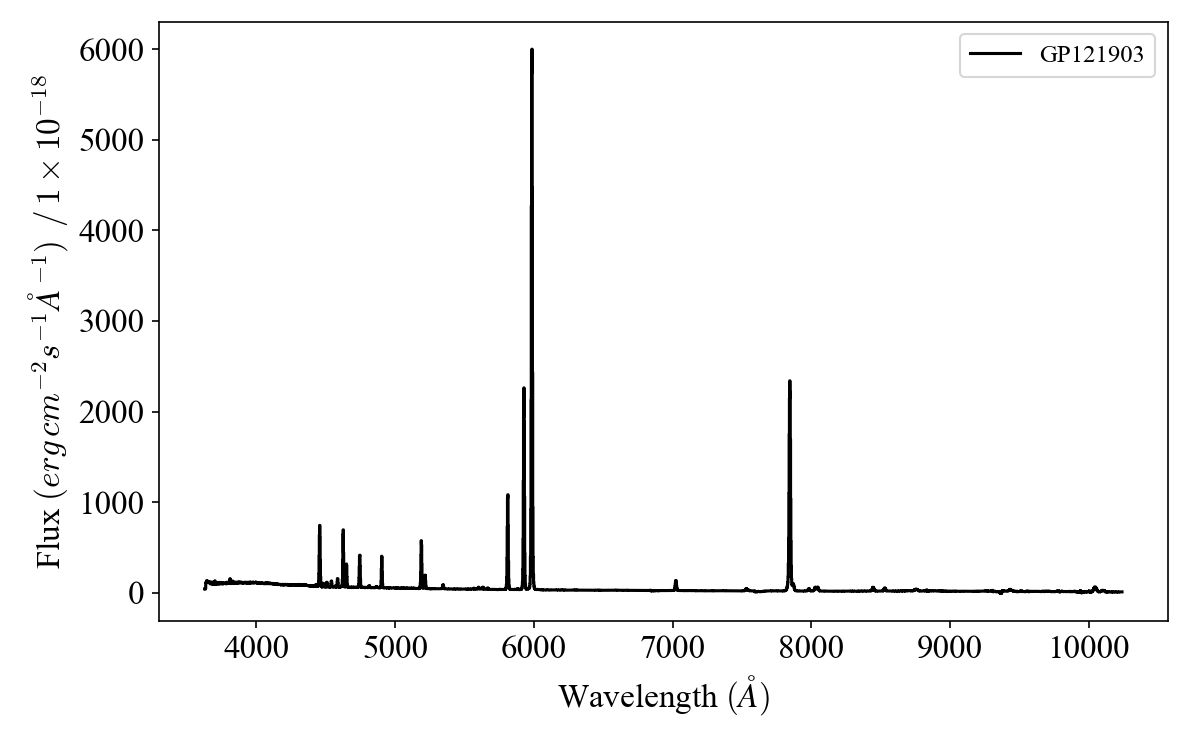

In [8]:
gp_spec.plot.spectrum(label='GP121903')

## Perform the fittings

To measure lines you use the functions from the `fit` attribute. For example, in the case of a single line you would use the ``fit.band``. For example, to measure of $H\alpha$ you can use:

In [9]:
gp_spec.fit.band(6563)

To plot the lattest fitting you can run:

<IPython.core.display.Javascript object>


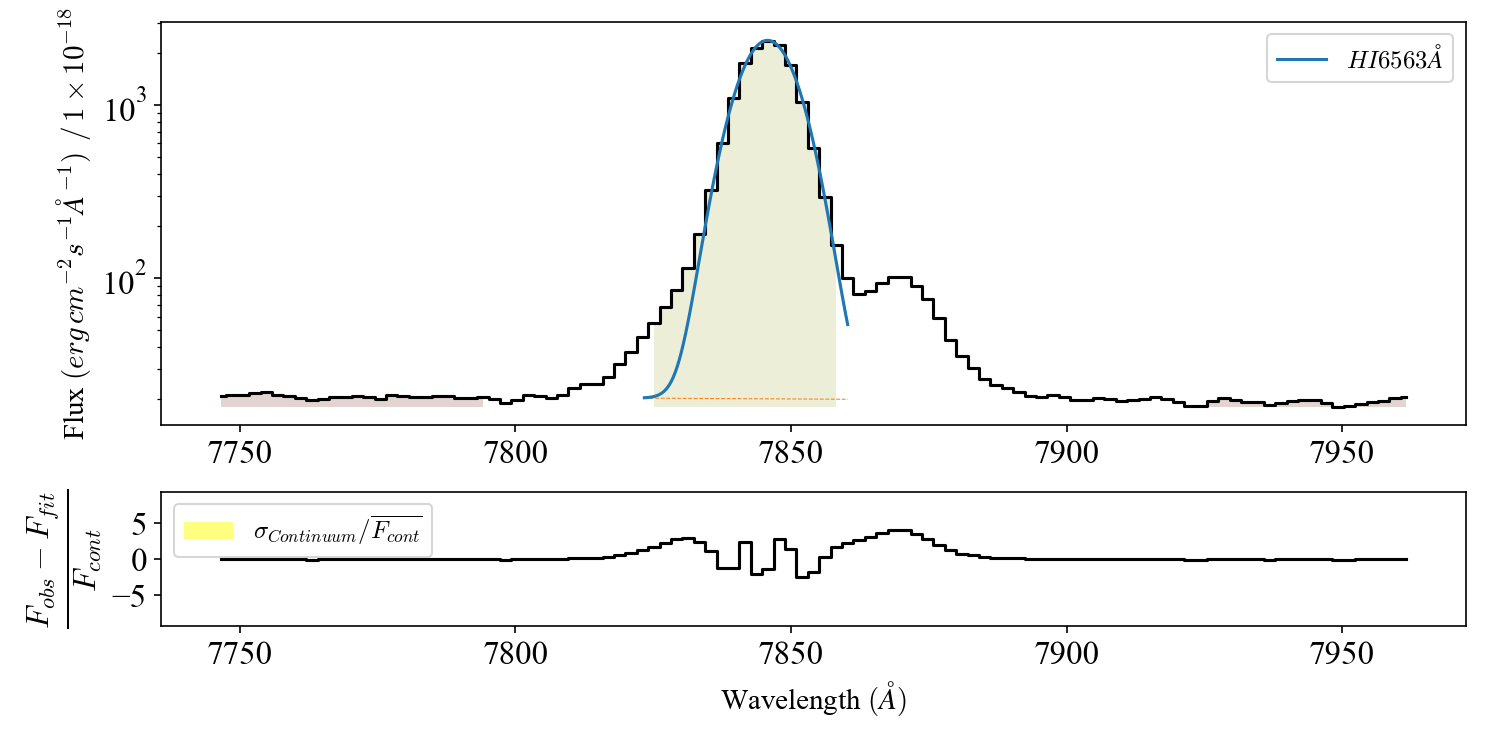

In [10]:
gp_spec.plot.band()

It is recommended, however, that users employ $LiMe$ label notation and provide their own line bands which take into account the spectrum resolution and emission features width. For example: 

In [11]:
# Line name and its location mask in the rest _frame
line = 'H1_6563A'
band_edges = np.array([6438.03, 6508.66, 6535.10, 6600.95, 6627.70, 6661.82])

We repeat now the fitting:

<IPython.core.display.Javascript object>


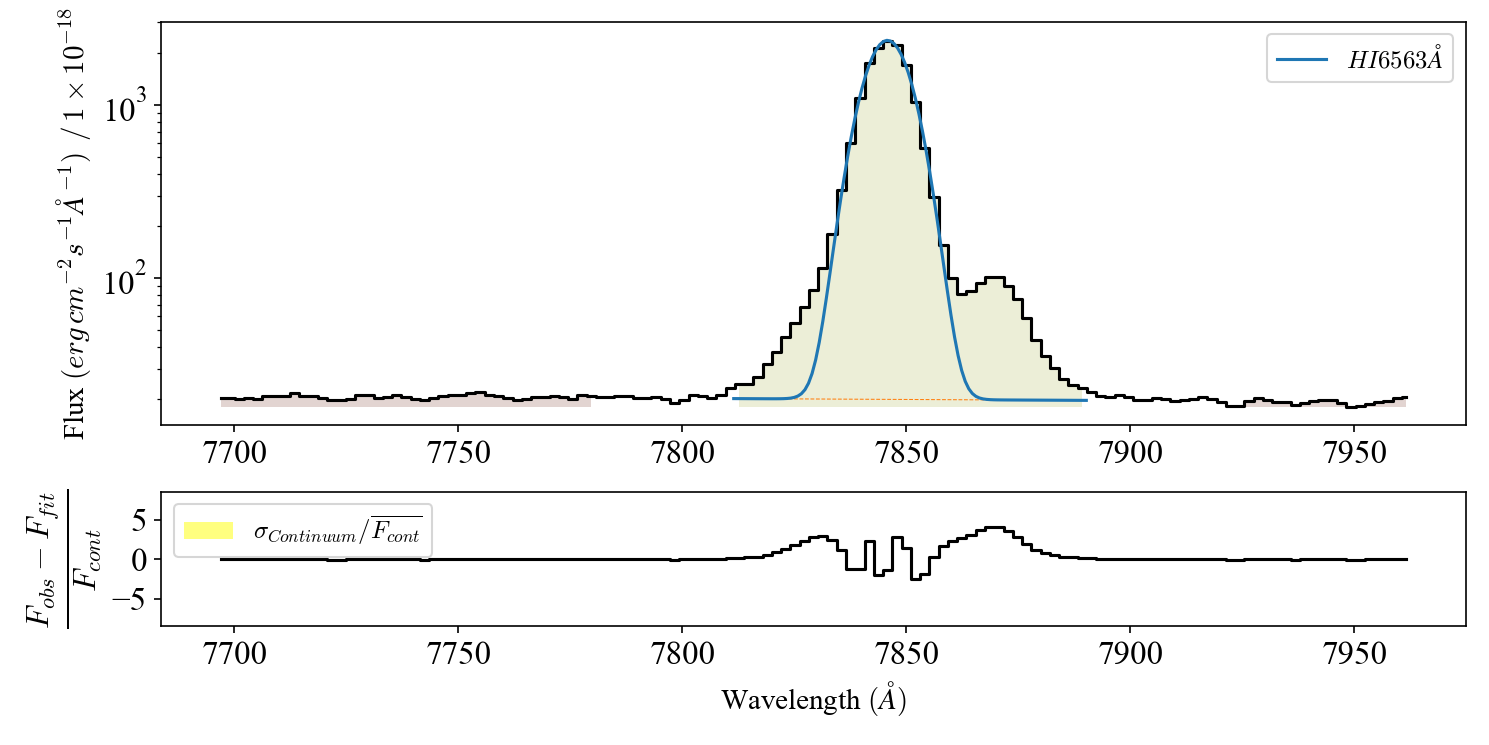

In [12]:
# Run the fitting and plot it
gp_spec.fit.band(line, band_edges)
gp_spec.plot.band()

You can see that the result was not very good. Let’s increase the complexity by including the $[NII]$ doublet:

In [13]:
# Fit configuration
line = 'H1_6563A_b'
fit_conf = {'H1_6563A_b': 'H1_6563A-N2_6584A-N2_6548A',
            'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
            'N2_6548A_kinem': 'N2_6584A'}

The dictionary above we have three elements:
- The line labelled as *H1_6563A_b* consists in three components: *H1_6563A*, *N2_6584A* and *N2_6548A*.
- The line labelled as *N2_6548A* has an amplitude fixed by the amplitude of *N2_6584A*.
- The line labelled as *N2_6548A* has its kinematics (both radial and dispersion velocity) tied to those of *N2_6584A*.

We repeat the fitting including this configuration:

<IPython.core.display.Javascript object>


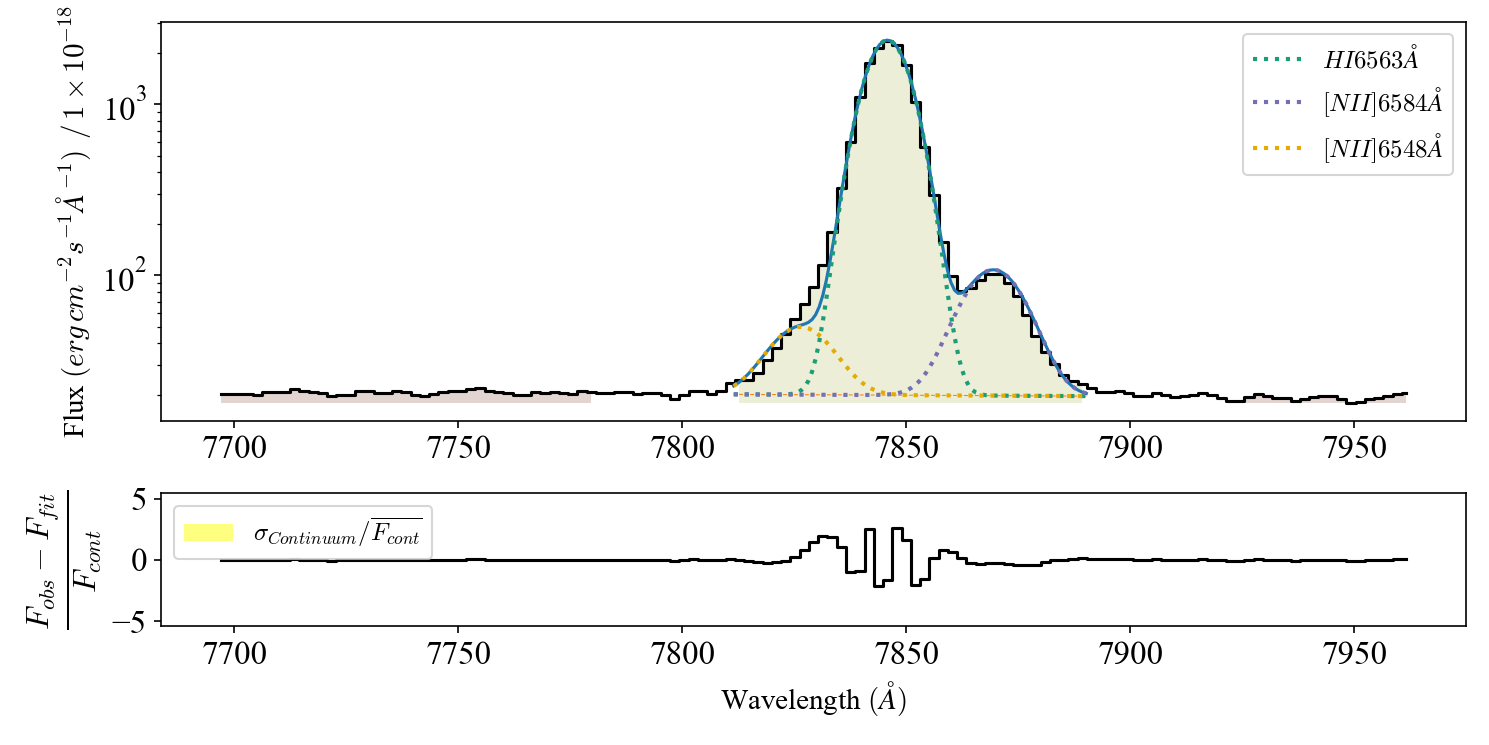

In [14]:
# New attempt including the fit configuration
gp_spec.fit.band(line, band_edges, fit_conf=fit_conf)
gp_spec.plot.band(line)

<div class="alert alert-info">

**Please remember:** To declare a multi-Gaussian fitting, two conditions are necessary: The line label must have the **_b**  suffix *(H1_6563A_b)* and the line components must be specified in the **fit_conf** dictionary *(H1_6563A-N2_6584A-N2_6548A)*.

</div>

## Save the results

You can store a plot into an image file by adding an output address:

<IPython.core.display.Javascript object>


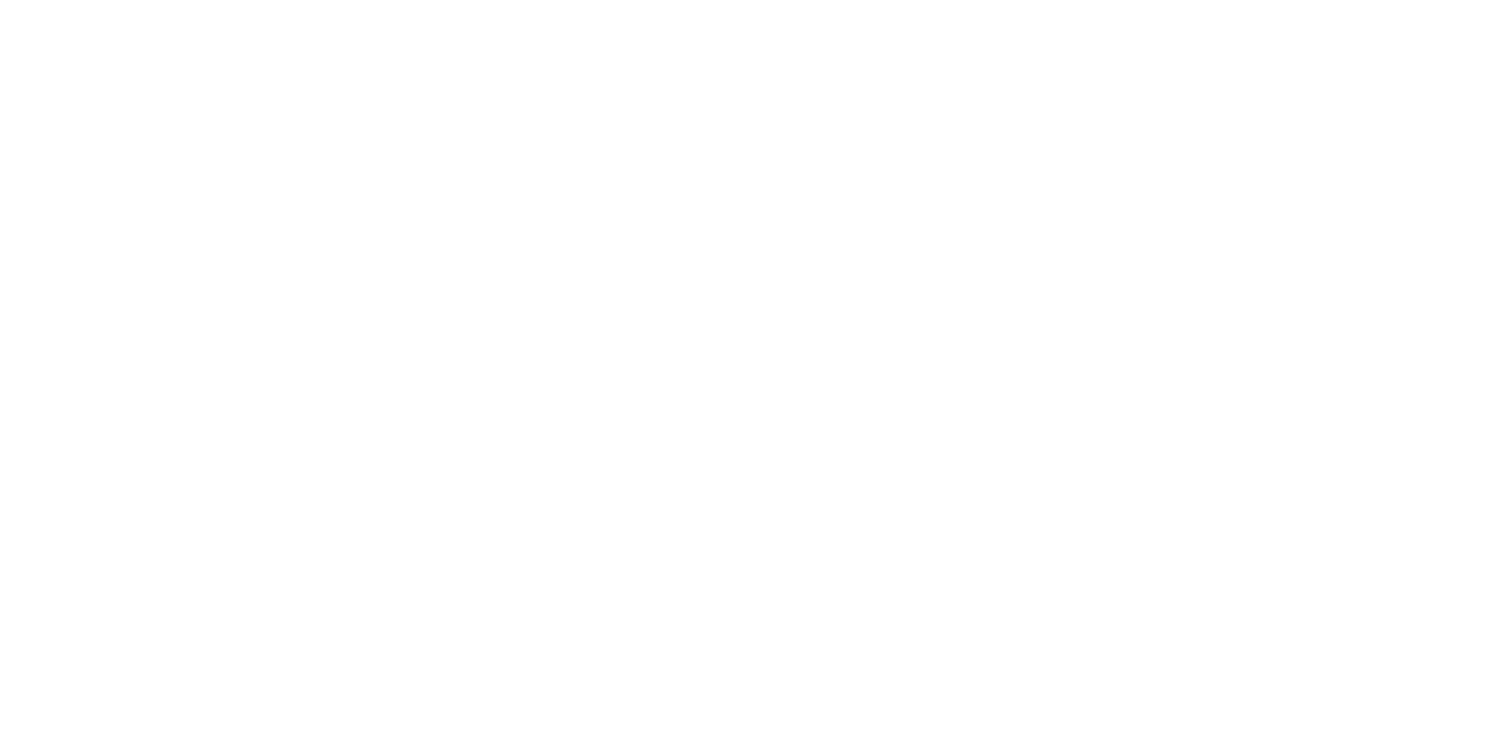

In [15]:
# You can also save the fitting plot to a file
gp_spec.plot.band(output_address=f'./sample_data/{line}.png')

The measurements are stored into the spectrum ``log``:

In [16]:
# Each fit is stored in the lines dataframe (log) attribute
print(gp_spec.log)

          wavelength     intg_flux      intg_err    gauss_flux     gauss_err  \
H1_6563A      6563.0  3.128548e-14  8.729274e-18  2.918097e-14  1.108646e-16   
N2_6584A      6584.0  3.128548e-14  8.729274e-18  1.476068e-15  1.198697e-16   
N2_6548A      6548.0  3.128548e-14  8.729274e-18  4.993188e-16  6.164800e-17   

                  eqw   eqw_err ion     latex_label  \
H1_6563A  1464.890899  5.565424  H1     $HI6563\AA$   
N2_6584A    74.098922  6.017485  N2  $[NII]6584\AA$   
N2_6548A    25.065906  0.000000  N2  $[NII]6548\AA$   

                       profile_label  ...       v_5        v_10        v_90  \
H1_6563A  H1_6563A-N2_6584A-N2_6548A  ... -400.5692 -304.864019  254.106636   
N2_6584A  H1_6563A-N2_6584A-N2_6548A  ... -400.5692 -304.864019  254.106636   
N2_6548A  H1_6563A-N2_6584A-N2_6548A  ... -400.5692 -304.864019  254.106636   

                v_95        chisqr     redchi         aic         bic  \
H1_6563A  427.453244  42224.143691  439.83483  626.629014  642.37885

This log can be saved into a file using the ``save_log`` attribute. The extention specifies the file type. You can also constrain the output measurements in addition to file sheet (only for multi-page file types) 

In [17]:
# It can be saved into different types of document using the function
gp_spec.save_log('./sample_data/example1_linelog.txt')
gp_spec.save_log('./sample_data/example1_linelog.pdf', param_list=['eqw', 'gauss_flux', 'gauss_err'])
gp_spec.save_log('./sample_data/example1_linelog.fits', ext='GP121903')
gp_spec.save_log('./sample_data/example1_linelog.xlsx', ext='GP121903')
gp_spec.save_log('./sample_data/example1_linelog.asdf', ext='GP121903')

A lines log can also be saved/loaded using the $LiMe$ functions:

In [18]:
log_address = './sample_data/example1_linelog.fits'
lime.save_log(gp_spec.log, log_address, ext='GP121903')
log = lime.load_log(log_address, ext='GP121903')
print(log)

          wavelength     intg_flux      intg_err    gauss_flux     gauss_err  \
index                                                                          
H1_6563A      6563.0  3.128548e-14  8.729274e-18  2.918097e-14  1.108646e-16   
N2_6584A      6584.0  3.128548e-14  8.729274e-18  1.476068e-15  1.198697e-16   
N2_6548A      6548.0  3.128548e-14  8.729274e-18  4.993188e-16  6.164800e-17   

                  eqw   eqw_err ion     latex_label  \
index                                                 
H1_6563A  1464.890899  5.565424  H1     $HI6563\AA$   
N2_6584A    74.098922  6.017485  N2  $[NII]6584\AA$   
N2_6548A    25.065906  0.000000  N2  $[NII]6548\AA$   

                       profile_label  ...       v_5        v_10        v_90  \
index                                 ...                                     
H1_6563A  H1_6563A-N2_6584A-N2_6548A  ... -400.5692 -304.864019  254.106636   
N2_6584A  H1_6563A-N2_6584A-N2_6548A  ... -400.5692 -304.864019  254.106636   
N2_6548